In [20]:
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000075', '#808080', '#ffffff', '#000000'
]
model_list = [
    "ACCESS-ESM1-5", "CanESM5", "CESM2", "CNRM-CM6-1", "EC-Earth3",
    "GISS-E2-1-G", "GISS-E2-1-H", "INM-CM5-0", "IPSL-CM6A-LR",
    "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
    "MRI-ESM2-0", "NorCPM1", "UKESM1-0-LL"
]
model_colors = {model: unique_colors[i % len(unique_colors)] for i, model in enumerate(model_list)}


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from scipy import signal

conc_folder = "siarea_data/"
sea_ice_folder = "sispeed_data/"
wind_folder = "wind_speed_data/"

conc_files = sorted(glob.glob(os.path.join(conc_folder, "cmip6.historical.*.siarea.csv")))
sea_ice_files = sorted(glob.glob(os.path.join(sea_ice_folder, "*_sispeed.area_mean.csv")))
wind_files = sorted(glob.glob(os.path.join(wind_folder, "*_wind_speed.csv")))

conc_models = {os.path.basename(f).replace("cmip6.historical.", "").replace(".siarea.csv", ""): f 
               for f in conc_files}
sea_ice_models = {os.path.basename(f).replace("_sispeed.area_mean.csv", ""): f 
                  for f in sea_ice_files}
wind_models = {os.path.basename(f).replace("_wind_speed.csv", ""): f 
               for f in wind_files}

common_models = set(conc_models.keys()) & set(sea_ice_models.keys()) & set(wind_models.keys())
print("Common Models:", common_models)

Common Models: {'CanESM5', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MIROC6', 'CNRM-CM6-1', 'CESM2', 'EC-Earth3', 'ACCESS-ESM1-5', 'MPI-ESM1-2-LR'}


In [29]:
results = []  
for model in common_models:

    try:
        conc_df = pd.read_csv(conc_models[model], index_col="time", parse_dates=True)
    except ValueError:
        conc_df = pd.read_csv(conc_models[model], index_col=0, parse_dates=True)
    try:
        ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
    except ValueError:
        ice_df = pd.read_csv(sea_ice_models[model], index_col=0, parse_dates=True)
    try:
        wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    except ValueError:
        wind_df = pd.read_csv(wind_models[model], index_col=0, parse_dates=True)
    
    common_time = conc_df.index.intersection(ice_df.index)
    common_time = common_time.intersection(wind_df.index)
    if common_time.empty:
        print(f"No common dates for {model}")
        continue
    conc_df = conc_df.loc[common_time]
    ice_df = ice_df.loc[common_time]
    wind_df = wind_df.loc[common_time]

    conc_march = conc_df[conc_df.index.month == 3]
    ice_march = ice_df[ice_df.index.month == 3]
    wind_march = wind_df[wind_df.index.month == 3]
    if conc_march.empty or ice_march.empty or wind_march.empty:
        print(f"March data missing for model {model}")
        continue
    
    ensemble_members = conc_march.columns.intersection(ice_march.columns).intersection(wind_march.columns)
    if ensemble_members.empty:
        ensemble_members = conc_march.columns
        
    for ens in ensemble_members:
        conc_ens = conc_march[ens]
        ice_ens = ice_march[ens]
        wind_ens = wind_march[ens]
        
        mean_conc = (conc_ens.mean())      # m²
        mean_ice_vel = ice_ens.mean()       # m/s.
        mean_wind = wind_ens.mean()           # m/s.
        
        if mean_wind == 0:
            ratio_vel_wind = np.nan
        else:
            ratio_vel_wind = mean_ice_vel / mean_wind
        if mean_conc == 0:
            ratio_vel_area = np.nan
        else:
            ratio_vel_area = mean_ice_vel / mean_conc
        
        results.append({
            "Model": model,
            "Ensemble": ens,
            "Mean Sea Ice Area (km², March)": mean_conc,
            "Mean Sea Ice Velocity (m/s, March)": mean_ice_vel,
            "Mean Wind Speed (m/s, March)": mean_wind,
            "Velocity/Wind": ratio_vel_wind,
            "Velocity/Area": ratio_vel_area
        })

results_df = pd.DataFrame(results)
print("Derived Metrics for March (by Ensemble):")
print(results_df)

Derived Metrics for March (by Ensemble):
            Model   Ensemble  Mean Sea Ice Area (km², March)  \
0         CanESM5  r25i1p1f1                    1.557640e+13   
1         CanESM5  r21i1p1f1                    1.591262e+13   
2         CanESM5   r7i1p1f1                    1.535491e+13   
3         CanESM5   r4i1p2f1                    1.609745e+13   
4         CanESM5  r25i1p2f1                    1.612764e+13   
..            ...        ...                             ...   
95  MPI-ESM1-2-LR   r4i1p1f1                    1.474734e+13   
96  MPI-ESM1-2-LR   r1i1p1f1                    1.434378e+13   
97  MPI-ESM1-2-LR   r2i1p1f1                    1.466754e+13   
98  MPI-ESM1-2-LR   r9i1p1f1                    1.443601e+13   
99  MPI-ESM1-2-LR   r3i1p1f1                    1.450470e+13   

    Mean Sea Ice Velocity (m/s, March)  Mean Wind Speed (m/s, March)  \
0                             0.140412                      5.422866   
1                             0.144898        

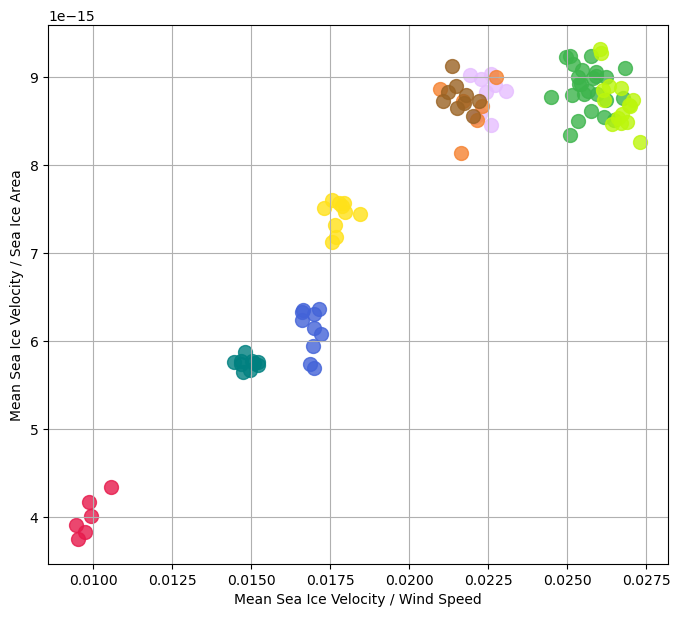

In [30]:
plt.figure(figsize=(8, 7))
plotted_models = set()
for idx, row in results_df.iterrows():
    model = row["Model"]
    x = row["Velocity/Wind"]
    y = row["Velocity/Area"]
    color = model_colors.get(model, "#000000")

    if model not in plotted_models:
        plt.scatter(x, y, color=color, s=100, alpha=0.8, label=model)
        plotted_models.add(model)
    else:
        plt.scatter(x, y, color=color, s=100, alpha=0.8)

plt.xlabel("Mean Sea Ice Velocity / Wind Speed")
plt.ylabel("Mean Sea Ice Velocity / Sea Ice Area")
# plt.title("Comparison of Sea Ice Drift Sensitivity (March) by Ensemble Member")
plt.grid(True)
# plt.legend(loc="best", fontsize="small", markerscale=0.8)
plt.savefig("final_drift_sensitivity_scatter_ensembles.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
results = []  
for model in common_models:

    try:
        conc_df = pd.read_csv(conc_models[model], index_col="time", parse_dates=True)
    except ValueError:
        conc_df = pd.read_csv(conc_models[model], index_col=0, parse_dates=True)
    try:
        ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
    except ValueError:
        ice_df = pd.read_csv(sea_ice_models[model], index_col=0, parse_dates=True)
    try:
        wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    except ValueError:
        wind_df = pd.read_csv(wind_models[model], index_col=0, parse_dates=True)
    
    common_time = conc_df.index.intersection(ice_df.index)
    common_time = common_time.intersection(wind_df.index)
    if common_time.empty:
        print(f"No common dates for {model}")
        continue
    conc_df = conc_df.loc[common_time]
    ice_df = ice_df.loc[common_time]
    wind_df = wind_df.loc[common_time]

    conc_march = conc_df[conc_df.index.month == 9]
    ice_march = ice_df[ice_df.index.month == 9]
    wind_march = wind_df[wind_df.index.month == 9]
    if conc_march.empty or ice_march.empty or wind_march.empty:
        print(f"March data missing for model {model}")
        continue
    
    ensemble_members = conc_march.columns.intersection(ice_march.columns).intersection(wind_march.columns)
    if ensemble_members.empty:
        ensemble_members = conc_march.columns
        
    for ens in ensemble_members:
        conc_ens = conc_march[ens]
        ice_ens = ice_march[ens]
        wind_ens = wind_march[ens]
        
        mean_conc = (conc_ens.mean())      # m²
        mean_ice_vel = ice_ens.mean()       # m/s.
        mean_wind = wind_ens.mean()           # m/s.
        
        if mean_wind == 0:
            ratio_vel_wind = np.nan
        else:
            ratio_vel_wind = mean_ice_vel / mean_wind
        if mean_conc == 0:
            ratio_vel_area = np.nan
        else:
            ratio_vel_area = mean_ice_vel / mean_conc
        
        results.append({
            "Model": model,
            "Ensemble": ens,
            "Mean Sea Ice Area (km², March)": mean_conc,
            "Mean Sea Ice Velocity (m/s, March)": mean_ice_vel,
            "Mean Wind Speed (m/s, March)": mean_wind,
            "Velocity/Wind": ratio_vel_wind,
            "Velocity/Area": ratio_vel_area
        })

results_df = pd.DataFrame(results)
print("Derived Metrics for September (by Ensemble):")
print(results_df)

Derived Metrics for September (by Ensemble):
            Model   Ensemble  Mean Sea Ice Area (km², March)  \
0         CanESM5  r25i1p1f1                    6.710004e+12   
1         CanESM5  r21i1p1f1                    6.653543e+12   
2         CanESM5   r7i1p1f1                    6.238074e+12   
3         CanESM5   r4i1p2f1                    7.390227e+12   
4         CanESM5  r25i1p2f1                    6.657858e+12   
..            ...        ...                             ...   
95  MPI-ESM1-2-LR   r4i1p1f1                    6.248259e+12   
96  MPI-ESM1-2-LR   r1i1p1f1                    6.119845e+12   
97  MPI-ESM1-2-LR   r2i1p1f1                    6.107192e+12   
98  MPI-ESM1-2-LR   r9i1p1f1                    5.996999e+12   
99  MPI-ESM1-2-LR   r3i1p1f1                    6.281270e+12   

    Mean Sea Ice Velocity (m/s, March)  Mean Wind Speed (m/s, March)  \
0                             0.122282                      5.155231   
1                             0.126337    

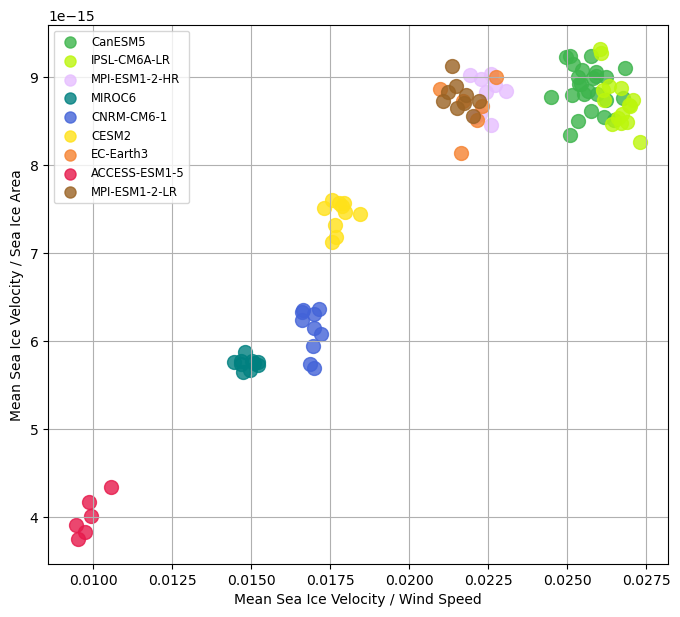

In [31]:
plt.figure(figsize=(8, 7))
plotted_models = set()
for idx, row in results_df.iterrows():
    model = row["Model"]
    x = row["Velocity/Wind"]
    y = row["Velocity/Area"]
    color = model_colors.get(model, "#000000")

    if model not in plotted_models:
        plt.scatter(x, y, color=color, s=100, alpha=0.8, label=model)
        plotted_models.add(model)
    else:
        plt.scatter(x, y, color=color, s=100, alpha=0.8)

plt.xlabel("Mean Sea Ice Velocity / Wind Speed")
plt.ylabel("Mean Sea Ice Velocity / Sea Ice Area")
# plt.title("Comparison of Sea Ice Drift Sensitivity (March) by Ensemble Member")
plt.grid(True)
plt.legend(loc="best", fontsize="small", markerscale=0.8)
plt.savefig("final_drift_sensitivity_scatter_ensembles.png", dpi=300, bbox_inches="tight")
plt.show()

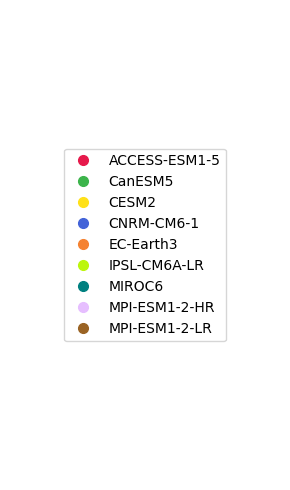

In [36]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

ordered_models = [
    "ACCESS-ESM1-5",
    "CanESM5",
    "CESM2",
    "CNRM-CM6-1",
    "EC-Earth3",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MPI-ESM1-2-LR",
]

model_colors = {     
    "ACCESS-ESM1-5": "#e6194b",
    "CanESM5": "#3cb44b",
    "CESM2": "#ffe119",
    "CNRM-CM6-1": "#4363d8",
    "EC-Earth3": "#f58231",
    "GISS-E2-1-G": "#911eb4",
    "GISS-E2-1-H": "#46f0f0",
    "INM-CM5-0": "#f032e6",
    "IPSL-CM6A-LR": "#bcf60c",
    "MIROC-ES2L": "#fabebe",
    "MIROC6": "#008080",
    "MPI-ESM1-2-HR": "#e6beff",
    "MPI-ESM1-2-LR": "#9a6324",
    "MRI-ESM2-0": "#fffac8",
    "NorCPM1": "#800000",
    "UKESM1-0-LL": "#aaffc3"
}

handles = []
for model in ordered_models:
    color = model_colors[model]
    if model == "Observations":
        handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                               markersize=10, label=model)
    else:
        handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                               markersize=7, label=model)
    handles.append(handle)

fig = plt.figure(figsize=(3, 5)) 
ax = fig.add_subplot(111)

legend = ax.legend(handles=handles, loc='center', frameon=True, fontsize=10)

ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
results = []  
for model in common_models:

    try:
        conc_df = pd.read_csv(conc_models[model], index_col="time", parse_dates=True)
    except ValueError:
        conc_df = pd.read_csv(conc_models[model], index_col=0, parse_dates=True)
    try:
        ice_df = pd.read_csv(sea_ice_models[model], index_col="time", parse_dates=True)
    except ValueError:
        ice_df = pd.read_csv(sea_ice_models[model], index_col=0, parse_dates=True)
    try:
        wind_df = pd.read_csv(wind_models[model], index_col="time", parse_dates=True)
    except ValueError:
        wind_df = pd.read_csv(wind_models[model], index_col=0, parse_dates=True)
    
    common_time = conc_df.index.intersection(ice_df.index)
    common_time = common_time.intersection(wind_df.index)
    if common_time.empty:
        print(f"No common dates for {model}")
        continue
    conc_df = conc_df.loc[common_time]
    ice_df = ice_df.loc[common_time]
    wind_df = wind_df.loc[common_time]

    conc_march = conc_df[conc_df.index.month == 3]
    ice_march = ice_df[ice_df.index.month == 3]
    wind_march = wind_df[wind_df.index.month == 3]
    if conc_march.empty or ice_march.empty or wind_march.empty:
        print(f"March data missing for model {model}")
        continue
    
    ensemble_members = conc_march.columns.intersection(ice_march.columns).intersection(wind_march.columns)
    if ensemble_members.empty:
        ensemble_members = conc_march.columns
        
    for ens in ensemble_members:
        conc_ens = conc_march[ens]
        ice_ens = ice_march[ens]
        wind_ens = wind_march[ens]
        
        mean_conc = (conc_ens.mean())      # m²
        mean_ice_vel = ice_ens.mean()       # m/s.
        mean_wind = wind_ens.mean()           # m/s.
        
        if mean_wind == 0:
            ratio_vel_wind = np.nan
        else:
            ratio_vel_wind = mean_ice_vel / mean_wind
        if mean_conc == 0:
            ratio_vel_area = np.nan
        else:
            ratio_vel_area = mean_ice_vel / mean_conc
        
        results.append({
            "Model": model,
            "Ensemble": ens,
            "Mean Sea Ice Area (km², March)": mean_conc,
            "Mean Sea Ice Velocity (m/s, March)": mean_ice_vel,
            "Mean Wind Speed (m/s, March)": mean_wind,
            "Velocity/Wind": ratio_vel_wind,
            "Velocity/Area": ratio_vel_area
        })

results_df = pd.DataFrame(results)
print("Derived Metrics for March (by Ensemble):")
print(results_df)

In [40]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

conc_folder    = "siarea_data/"      
vel_folder     = "sispeed_data/"    
thick_folder   = "sithick_data/"    

conc_files  = sorted(glob.glob(os.path.join(conc_folder,  "cmip6.historical.*.siarea.csv")))
vel_files   = sorted(glob.glob(os.path.join(vel_folder,   "*_sispeed.area_mean.csv")))
thick_files = sorted(glob.glob(os.path.join(thick_folder, "*_sithick.csv")))

conc_models  = {
    os.path.basename(f)
      .replace("cmip6.historical.", "")
      .replace(".siarea.csv", ""): f
    for f in conc_files
}
vel_models   = {
    os.path.basename(f)
      .replace("_sispeed.area_mean.csv", ""): f
    for f in vel_files
}
thick_models = {
    os.path.basename(f)
      .replace("_sithick.csv", ""): f
    for f in thick_files
}

common_models = set(conc_models) & set(vel_models) & set(thick_models)

results = []
for model in sorted(common_models):
    conc = pd.read_csv(conc_models[model],    index_col=0, parse_dates=True)
    vel  = pd.read_csv(vel_models[model],     index_col=0, parse_dates=True)
    thick= pd.read_csv(thick_models[model],   index_col=0, parse_dates=True)

    conc = conc.resample("M").mean()
    vel   = vel.resample("M").mean()
    thick = thick.resample("M").mean()

    idx = conc.index.intersection(vel.index).intersection(thick.index)
    conc, vel, thick = conc.loc[idx], vel.loc[idx], thick.loc[idx]

    conc_m  = conc[conc.index.month == 3]
    vel_m   = vel[vel.index.month == 3]
    thick_m = thick[thick.index.month == 3]

    members = (
        conc_m.columns
              .intersection(vel_m.columns)
              .intersection(thick_m.columns)
    )

    for ens in members:
        m_area  = conc_m[ens].mean(skipna=True)    # km²
        m_vel   = vel_m[ens].mean(skipna=True)     # m/s
        m_thick = thick_m[ens].mean(skipna=True)   # m

        ratio = m_vel / m_area if m_area > 0 else np.nan

        results.append({
            "Model":              model,
            "Ensemble":           ens,
            "Mean Thickness (m)": m_thick,
            "Mean Area (km²)":    m_area,
            "Mean Velocity (m/s)":m_vel,
            "Velocity/Area (s⁻¹)":ratio
        })

df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
for model, sub in df.groupby("Model"):
    color = model_colors.get(model, "#000000")
    plt.scatter(
        sub["Mean Thickness (m)"],
        sub["Velocity/Area (s⁻¹)"],
        label=model,
        alpha=0.7,
        color=color
        markerscale=80
    )

plt.xlabel("Mean Sea Ice Thickness (m)")
plt.ylabel("Mean Drift speed / Area (s⁻¹)")
# plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (3431608547.py, line 85)

In [44]:
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000075', '#808080', '#ffffff', '#000000'
]
model_list = [
    "ACCESS-ESM1-5", "CanESM5", "CESM2", "CNRM-CM6-1", "EC-Earth3",
    "GISS-E2-1-G", "GISS-E2-1-H", "INM-CM5-0", "IPSL-CM6A-LR",
    "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
    "MRI-ESM2-0", "NorCPM1", "UKESM1-0-LL"
]
model_colors = {model: unique_colors[i % len(unique_colors)] for i, model in enumerate(model_list)}


/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/2514722813.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  thick_m = thick_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/2514722813.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vel_m   = vel_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/2514722813.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wind_m  = wind_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/2514722813.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  thick_m = thick_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/2514722813.py:33: FutureWarning: 'M' is de

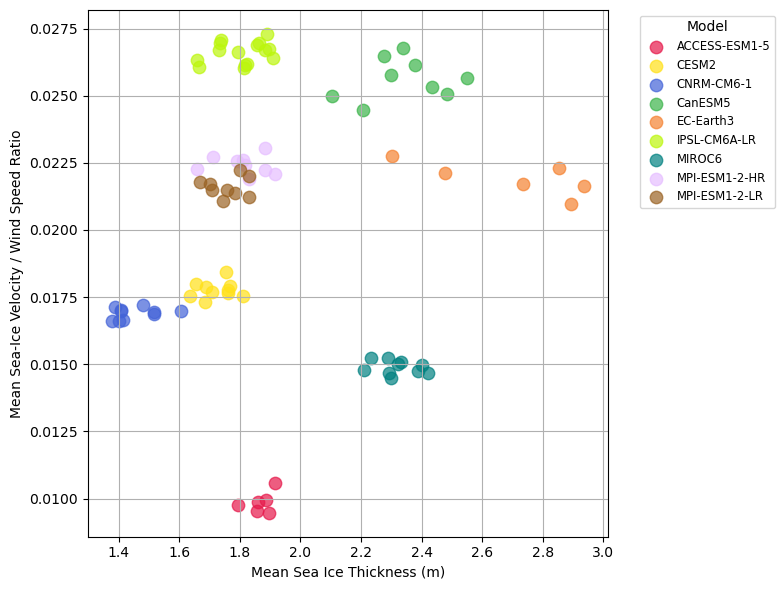

In [45]:
#MARCH 

import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


thick_folder = "sithick_data/"      
vel_folder   = "sispeed_data/"      
wind_folder  = "wind_speed_data/"   

thick_files = glob.glob(os.path.join(thick_folder, "*_sithick.csv"))
vel_files   = glob.glob(os.path.join(vel_folder,   "*_sispeed.area_mean.csv"))
wind_files  = glob.glob(os.path.join(wind_folder,  "*_wind_speed.csv"))

thick_models = {os.path.basename(f).replace("_sithick.csv",""): f for f in thick_files}
vel_models   = {os.path.basename(f).replace("_sispeed.area_mean.csv",""): f for f in vel_files}
wind_models  = {os.path.basename(f).replace("_wind_speed.csv",""): f for f in wind_files}

common_models = set(thick_models) & set(vel_models) & set(wind_models)

# Compute March means and velocity/wind ratio per ensemble 
results = []
for model in sorted(common_models, key=lambda m: model_list.index(m) if m in model_list else -1):
    # load CSVs (first column as datetime index)
    thick_df = pd.read_csv(thick_models[model], index_col=0, parse_dates=True)
    vel_df   = pd.read_csv(vel_models[model],   index_col=0, parse_dates=True)
    wind_df  = pd.read_csv(wind_models[model],  index_col=0, parse_dates=True)

    # aggregate to monthly means
    thick_m = thick_df.resample("M").mean()
    vel_m   = vel_df.resample("M").mean()
    wind_m  = wind_df.resample("M").mean()

    idx      = thick_m.index.intersection(vel_m.index).intersection(wind_m.index)
    thick_m  = thick_m.loc[idx]
    vel_m    = vel_m.loc[idx]
    wind_m   = wind_m.loc[idx]

    thick_mar = thick_m[thick_m.index.month == 3]
    vel_mar   = vel_m[vel_m.index.month   == 3]
    wind_mar  = wind_m[wind_m.index.month  == 3]

    members = thick_mar.columns.intersection(vel_mar.columns).intersection(wind_mar.columns)

    for ens in members:
        mean_thick = thick_mar[ens].mean(skipna=True)  # m
        mean_vel   = vel_mar[ens].mean(skipna=True)    # m/s
        mean_wind  = wind_mar[ens].mean(skipna=True)   # m/s

        ratio = mean_vel / mean_wind if mean_wind != 0 else np.nan

        results.append({
            "Model":               model,
            "Ensemble":            ens,
            "Mean Thickness (m)":  mean_thick,
            "Velocity/Wind Ratio": ratio
        })

# 3) Build DataFrame
df = pd.DataFrame(results)

# 4) Plot: x = thickness, y = velocity/wind ratio
plt.figure(figsize=(8, 6))
for model, sub in df.groupby("Model"):
    color = model_colors.get(model, "#000000")
    plt.scatter(
        sub["Mean Thickness (m)"],
        sub["Velocity/Wind Ratio"],
        label=model,
        color=color,
        alpha=0.7,
        s=80
    )

plt.xlabel("Mean Sea Ice Thickness (m)")
plt.ylabel("Mean Sea‐Ice Velocity / Wind Speed Ratio")
plt.legend(
    title="Model",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small"
)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/1192638346.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  thick_m = thick_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/1192638346.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vel_m   = vel_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/1192638346.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wind_m  = wind_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/1192638346.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  thick_m = thick_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/1192638346.py:9: FutureWarning: 'M' is deprec

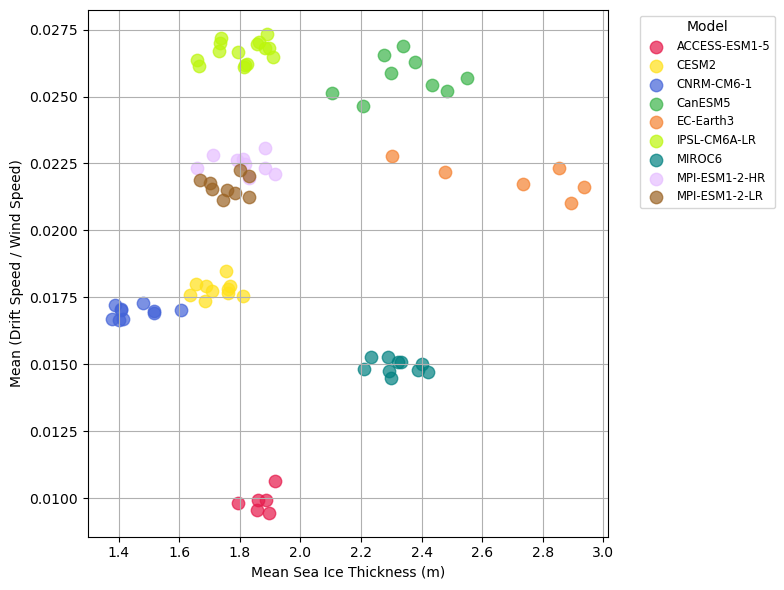

In [32]:
# compute the ratio time series first and then take mean

results = []
for model in sorted(common_models, key=lambda m: model_list.index(m) if m in model_list else -1):
    
    thick_df = pd.read_csv(thick_models[model], index_col=0, parse_dates=True)
    vel_df   = pd.read_csv(vel_models[model],   index_col=0, parse_dates=True)
    wind_df  = pd.read_csv(wind_models[model],  index_col=0, parse_dates=True)

    thick_m = thick_df.resample("M").mean()
    vel_m   = vel_df.resample("M").mean()
    wind_m  = wind_df.resample("M").mean()

    idx      = thick_m.index.intersection(vel_m.index).intersection(wind_m.index)
    thick_m  = thick_m.loc[idx]
    vel_m    = vel_m.loc[idx]
    wind_m   = wind_m.loc[idx]

    thick_mar = thick_m[thick_m.index.month == 3]
    vel_mar   = vel_m[vel_m.index.month   == 3]
    wind_mar  = wind_m[wind_m.index.month  == 3]

    members = thick_mar.columns.intersection(vel_mar.columns).intersection(wind_mar.columns)
    for ens in members:
        ratio_ts   = vel_mar[ens] / wind_mar[ens]
        mean_ratio = ratio_ts.mean(skipna=True)

        mean_thick = thick_mar[ens].mean(skipna=True)

        results.append({
            "Model":               model,
            "Ensemble":            ens,
            "Mean Thickness (m)":  mean_thick,
            "Mean Ratio":          mean_ratio
        })

df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
for model, sub in df.groupby("Model"):
    plt.scatter(
        sub["Mean Thickness (m)"],
        sub["Mean Ratio"],
        label=model,
        color=model_colors.get(model, "#000000"),
        alpha=0.7,
        s=80
    )

plt.xlabel("Mean Sea Ice Thickness (m)")
plt.ylabel("Mean (Drift Speed / Wind Speed)")
plt.legend(
    title="Model",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small"
)
plt.grid(True)
plt.tight_layout()
plt.show()


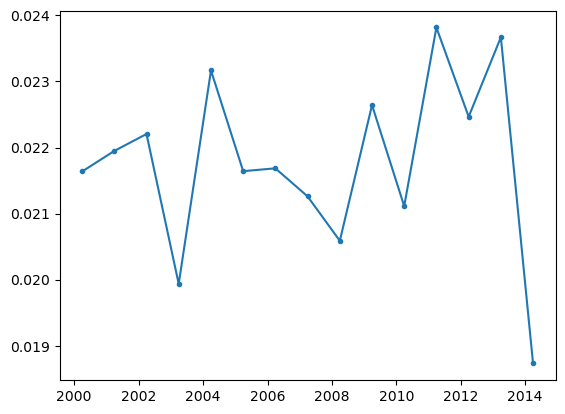

In [34]:
plt.plot(ratio_ts,marker=".")

/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/4160186918.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  thick_m = thick_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/4160186918.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vel_m   = vel_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/4160186918.py:44: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wind_m  = wind_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/4160186918.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  thick_m = thick_df.resample("M").mean()
/var/folders/t7/4flnfkx542q3fx0syy1n_pww0000gn/T/ipykernel_10571/4160186918.py:43: FutureWarning: 'M' is de

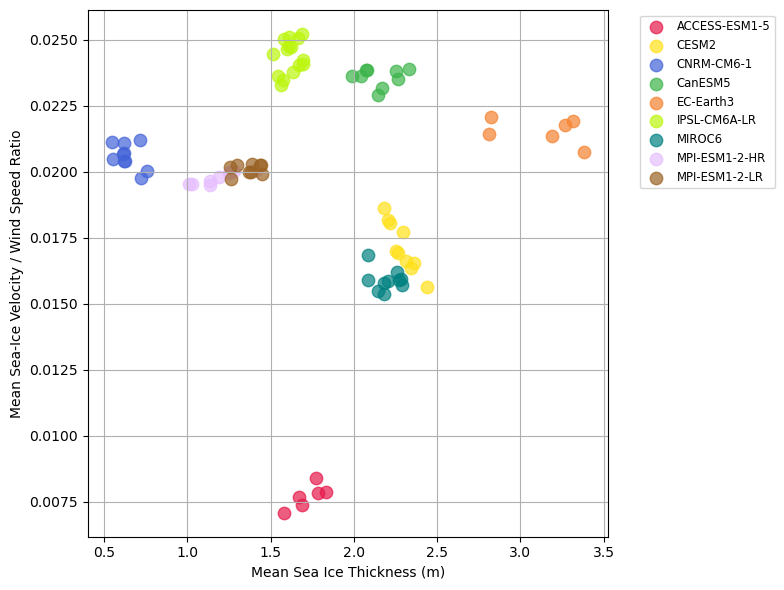

In [42]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000075', '#808080', '#ffffff', '#000000'
]
model_list = [
    "ACCESS-ESM1-5", "CanESM5", "CESM2", "CNRM-CM6-1", "EC-Earth3",
    "GISS-E2-1-G", "GISS-E2-1-H", "INM-CM5-0", "IPSL-CM6A-LR",
    "MIROC-ES2L", "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
    "MRI-ESM2-0", "NorCPM1", "UKESM1-0-LL"
]
model_colors = {model: unique_colors[i % len(unique_colors)] for i, model in enumerate(model_list)}

thick_folder = "sithick_data/"      
vel_folder   = "sispeed_data/"      
wind_folder  = "wind_speed_data/"

thick_files = glob.glob(os.path.join(thick_folder, "*_sithick.csv"))
vel_files   = glob.glob(os.path.join(vel_folder,   "*_sispeed.area_mean.csv"))
wind_files  = glob.glob(os.path.join(wind_folder,  "*_wind_speed.csv"))

thick_models = {os.path.basename(f).replace("_sithick.csv",""): f for f in thick_files}
vel_models   = {os.path.basename(f).replace("_sispeed.area_mean.csv",""): f for f in vel_files}
wind_models  = {os.path.basename(f).replace("_wind_speed.csv",""): f for f in wind_files}

common_models = set(thick_models) & set(vel_models) & set(wind_models)

results = []
for model in sorted(common_models, key=lambda m: model_list.index(m) if m in model_list else -1):
    thick_df = pd.read_csv(thick_models[model], index_col=0, parse_dates=True)
    vel_df   = pd.read_csv(vel_models[model],   index_col=0, parse_dates=True)
    wind_df  = pd.read_csv(wind_models[model],  index_col=0, parse_dates=True)

    thick_m = thick_df.resample("M").mean()
    vel_m   = vel_df.resample("M").mean()
    wind_m  = wind_df.resample("M").mean()

    idx      = thick_m.index.intersection(vel_m.index).intersection(wind_m.index)
    thick_m  = thick_m.loc[idx]
    vel_m    = vel_m.loc[idx]
    wind_m   = wind_m.loc[idx]

    # September
    thick_mar = thick_m[thick_m.index.month == 9]
    vel_mar   = vel_m[vel_m.index.month   == 9]
    wind_mar  = wind_m[wind_m.index.month  == 9]

    members = thick_mar.columns.intersection(vel_mar.columns).intersection(wind_mar.columns)

    for ens in members:
        mean_thick = thick_mar[ens].mean(skipna=True)  # m
        mean_vel   = vel_mar[ens].mean(skipna=True)    # m/s
        mean_wind  = wind_mar[ens].mean(skipna=True)   # m/s

        ratio = mean_vel / mean_wind if mean_wind != 0 else np.nan

        results.append({
            "Model":               model,
            "Ensemble":            ens,
            "Mean Thickness (m)":  mean_thick,
            "Velocity/Wind Ratio": ratio
        })

df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
for model, sub in df.groupby("Model"):
    color = model_colors.get(model, "#000000")
    plt.scatter(
        sub["Mean Thickness (m)"],
        sub["Velocity/Wind Ratio"],
        label=model,
        color=color,
        alpha=0.7,
        s=80
    )

plt.xlabel("Mean Sea Ice Thickness (m)")
plt.ylabel("Mean Sea‐Ice Velocity / Wind Speed Ratio")
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize="small"
)
plt.grid(True)
plt.tight_layout()
plt.show()
